This notebook is an example of what happens when someone with very little knowledge or experience in probabilistic programming languages, looks at some tutorials, gets some data, and cut'n'pastes things together and shuffles them around until something runs.

This is certainly wrong, but can hopefully provide a baseline for a working model. 

In [1]:
import os

import pandas as pd

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt


Get a sample of player data.  Just look at forwards, with data up to the middle of the 2019/20 season.

In [2]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.utils import get_player

In [3]:
def get_player_data(position, season="1920", latest_gameweek=38):
    data, names = process_player_data(position,season, latest_gameweek)
    return data, names

In [4]:
data, names = get_player_data("FWD")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

this gives us "names", which is actually a list of player_ids, and the "data" is a dict with keys "nplayer" (int), "nmatch" (int), "minutes" (numpy array with shape (nplayer, nmatch)), "y" (numpy array with shape (nplayer, nmatch, 3)), and "alpha" (numpy array with shape (3,)).


### numpyro model

The below took a lot of iterations to figure out how to broadcast over the right dimensions.
Hopefully it's sort-of right...


In [5]:
def model(nplayer, nmatch, minutes, y, alpha):
    theta = dist.Dirichlet(concentration=alpha)
    # one sample from the prior per player
    with numpyro.plate("nplayer", nplayer) as player_index:
        dprobs = numpyro.sample("probs", theta) 
    # now it's all about how to broadcast in the right dimensions.....
    prob_score = numpyro.deterministic("prob_score",dprobs[:,0,None] * (minutes / 90.))
    prob_assist = numpyro.deterministic("prob_assist",dprobs[:,1,None] * (minutes / 90.))
    prob_neither = numpyro.deterministic("prob_neither",dprobs[:,2,None] * (minutes / 90.) + (90. - minutes))
    theta_mins = dist.Multinomial(
                probs=jnp.moveaxis(jnp.array([prob_score, prob_assist, prob_neither]),0,2)
    )
    return numpyro.sample("obs", theta_mins, obs=y)

In [6]:
def fit_model(data, model):
    kernel = NUTS(model)
    mcmc = MCMC(
    kernel,
    num_warmup=1500,
    num_samples=3000,
    num_chains=1,
    progress_bar=True
    )
    rng_key, rng_key_predict = random.split(random.PRNGKey(44))
    mcmc.run(rng_key,
         data["nplayer"],
         data["nmatch"],
         data["minutes"],
         data["y"],
         data["alpha"]
    )
    return mcmc.get_samples()

In [7]:
def get_probs(player_index, samples):
    prob_score = float(samples["probs"][:,player_index,0].mean())
    prob_assist = float(samples["probs"][:,player_index,1].mean())
    prob_neither = float(samples["probs"][:,player_index,2].mean())
    return (prob_score, prob_assist, prob_neither)

In [8]:
def create_dataframe(names, samples):
    prob_dict = {"name":[],"prob_score": [], "prob_assist": [], "prob_neither": []}
    for i, pid in enumerate(names):
        pid = int(pid)
        prob_dict["name"].append(get_player(pid).name)
        probs = get_probs(pid, samples)
        prob_dict["prob_score"].append(probs[0])
        prob_dict["prob_assist"].append(probs[1])
        prob_dict["prob_neither"].append(probs[2])
    df = pd.DataFrame(prob_dict)
    return df

In [9]:
def run_model(position="FWD",season="1920",latest_gameweek=38):
    data, names = get_player_data(position, season, latest_gameweek)
    samples = fit_model(data, model)
    df = create_dataframe(names, samples)
    return df

Now go through the whole chain for each position in turn

In [10]:
df_fwd = run_model("FWD")
df_mid = run_model("MID")
df_def = run_model("DEF")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

sample: 100%|████████████████████████████████| 4500/4500 [00:11<00:00, 390.88it/s, 15 steps of size 3.95e-01. acc. prob=0.85]


Filling history dataframe for Mohamed Salah: 0/264 done
Filling history dataframe for Sadio Mané: 1/264 done
Filling history dataframe for Raheem Sterling: 2/264 done
Filling history dataframe for Kevin De Bruyne: 3/264 done
Filling history dataframe for Heung-Min Son: 4/264 done
Filling history dataframe for Nicolas Pépé: 5/264 done
Filling history dataframe for Leroy Sané: 6/264 done
Filling history dataframe for Bruno Miguel Borges Fernandes: 7/264 done
Filling history dataframe for Christian Eriksen: 8/264 done
Filling history dataframe for Riyad Mahrez: 9/264 done
Filling history dataframe for Bamidele Alli: 10/264 done
Filling history dataframe for Richarlison de Andrade: 11/264 done
Filling history dataframe for Paul Pogba: 12/264 done
Filling history dataframe for Anthony Martial: 13/264 done
Filling history dataframe for Bernardo Mota Veiga de Carvalho e Silva: 14/264 done
Filling history dataframe for James Maddison: 15/264 done
Filling history dataframe for Steven Bergwijn: 

Filling history dataframe for Moritz Leitner: 243/264 done
Filling history dataframe for Luke Dreher: 244/264 done
Filling history dataframe for Hamza Choudhury: 245/264 done
Filling history dataframe for Tahith Chong: 246/264 done
Filling history dataframe for Matty James: 247/264 done
Filling history dataframe for Keinan Davis: 248/264 done
Filling history dataframe for Nampalys Mendy: 249/264 done
Filling history dataframe for Oliver Skipp: 250/264 done
Filling history dataframe for James Garner: 251/264 done
Filling history dataframe for Tom Trybull: 252/264 done
Filling history dataframe for Emile Smith Rowe: 253/264 done
Filling history dataframe for Muhamed Bešić: 254/264 done
Filling history dataframe for Domingos Quina: 255/264 done
Filling history dataframe for Beram Kayal: 256/264 done
Filling history dataframe for Grady Diangana: 257/264 done
Filling history dataframe for James McCarthy: 258/264 done
Filling history dataframe for Oriol Romeu Vidal: 259/264 done
Filling hist

sample: 100%|████████████████████████████████| 4500/4500 [00:28<00:00, 158.02it/s, 15 steps of size 2.69e-01. acc. prob=0.87]


Filling history dataframe for Trent Alexander-Arnold: 0/215 done
Filling history dataframe for Andrew Robertson: 1/215 done
Filling history dataframe for Virgil van Dijk: 2/215 done
Filling history dataframe for Aymeric Laporte: 3/215 done
Filling history dataframe for Ricardo Domingos Barbosa Pereira: 4/215 done
Filling history dataframe for Matt Doherty: 5/215 done
Filling history dataframe for Marcos Alonso: 6/215 done
Filling history dataframe for Antonio Rüdiger: 7/215 done
Filling history dataframe for César Azpilicueta: 8/215 done
Filling history dataframe for Lucas Digne: 9/215 done
Filling history dataframe for David Luiz Moreira Marinho: 10/215 done
Filling history dataframe for Patrick van Aanholt: 11/215 done
Filling history dataframe for Kyle Walker: 12/215 done
Filling history dataframe for Benjamin Mendy: 13/215 done
Filling history dataframe for Benjamin Chilwell: 14/215 done
Filling history dataframe for Héctor Bellerín: 15/215 done
Filling history dataframe for Kieran

Alpha is [ 1.62627542  2.6862585  47.6827491 ]


sample: 100%|████████████████████████████████| 4500/4500 [00:22<00:00, 201.93it/s, 15 steps of size 2.51e-01. acc. prob=0.87]


Text(0, 0.5, 'P(assist)')

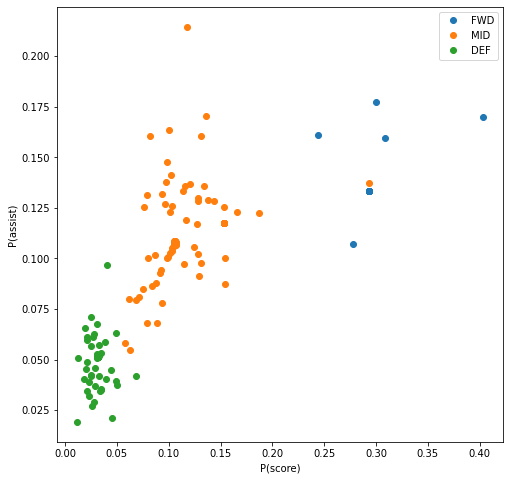

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.plot(df_fwd['prob_score'], df_fwd['prob_assist'], 'o', label='FWD')
plt.plot(df_mid['prob_score'], df_mid['prob_assist'], 'o', label='MID')
plt.plot(df_def['prob_score'], df_def['prob_assist'], 'o', label='DEF')
plt.legend()
plt.xlabel('P(score)')
plt.ylabel('P(assist)')


In [12]:
df_fwd.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
4,Wesley Moraes,0.403270,0.169930,0.426800
1,Alexandre Lacazette,0.308349,0.159546,0.532105
3,Gabriel Teodoro Martinelli Silva,0.300349,0.177191,0.522461
43,Glenn Murray,0.292898,0.133245,0.573857
55,Billy Sharp,0.292898,0.133245,0.573857
63,Patrick Cutrone,0.292898,0.133245,0.573857
62,Albian Ajeti,0.292898,0.133245,0.573857
61,Sébastien Haller,0.292898,0.133245,0.573857
60,Charlie Austin,0.292898,0.133245,0.573857
59,Shane Long,0.292898,0.133245,0.573857


Something definitely not right here... Pretty sure Wesley was not the best striker that season, and all but a few strikers have the same values for the different probabilities :( 